Code samples to classify MNIST dataset using Tensorflow, Keras and Pytorch

Ref:
*  https://tensorflow2.readthedocs.io/en/latest/tensorflow/g3doc/tutorials/mnist/pros/
*   https://gist.github.com/carlosedp/295c9609f8c438b8b5a86d74202a3901
*   https://www.kaggle.com/code/amyjang/tensorflow-mnist-cnn-tutorial
*   https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
*   https://medium.com/@kaushiktd/building-a-simple-neural-network-from-scratch-with-tensorflow-for-mnist-classification-bb25395bb8f1
*   https://github.com/everhusk/TensorFlow-MNIST/blob/master/lab.ipynb
*   https://github.com/Gurubux/CognitiveClass-DL/blob/master/2_Deep_Learning_with_TensorFlow/DL_CC_2_1_IntroductionToTensorFlow/1.1-Review-TensorFlow-Hello-World.ipynb



In [ ]:
# Loading all required packages
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Load the dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

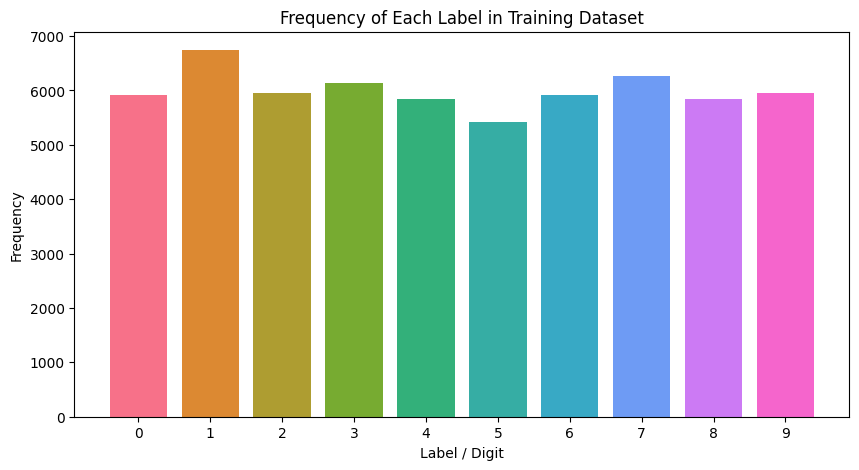

In [ ]:
#count of each digit
unique_labels, counts = np.unique(y_train, return_counts=True)
num_categories = len(unique_labels)

# Create bar graph
plt.figure(figsize=(10, 5))  # Adjust figure size if needed
ax = plt.bar(unique_labels, counts)
palette = sns.color_palette("husl", num_categories)
for i, bar in enumerate(ax.patches):
    bar.set_facecolor(palette[i])
plt.xticks(unique_labels)
plt.title('Frequency of Each Label in Training Dataset')
plt.xlabel('Label / Digit')
plt.ylabel('Frequency')
plt.show()


In [ ]:
#checking for data completeness
np.isnan(x_train).any()

False

In [ ]:
np.isnan(x_test).any()

False

The digit is:  5


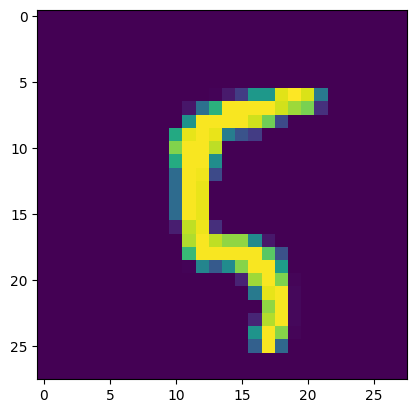

In [ ]:
plt.imshow(x_train[100])
print("The digit is: ", y_train[100])

In [ ]:
# Reshape and Normalization
x_train = x_train.reshape(-1, 28 * 28).astype("float32") / 255.0  # Flatten images and normalize
x_test = x_test.reshape(-1, 28 * 28).astype("float32") / 255.0

# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# TensorFlow

In [ ]:
class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        # Initialize weights and biases
        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.w = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.w) + self.b)

    @property
    def weights(self):
        return (self.w, self.b)

In [ ]:
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x

    @property
    def weights(self):
        weights = []
        for layer in self.layers:
            weights += layer.weights
        return weights

In [ ]:
# Instantiate the NaiveSequential model
model = NaiveSequential(layers=[
    NaiveDense(input_size=28*28, output_size=128, activation=tf.nn.relu),
    NaiveDense(input_size=128, output_size=64, activation=tf.nn.relu),
    NaiveDense(input_size=64, output_size=10, activation=tf.nn.softmax)
])

# Run the model on a sample batch to check the output
sample_output = model(x_train[:5])  # Pass a few samples through the model
print("Sample output shape:", sample_output.shape)  # Should be (5, 10)

Sample output shape: (5, 10)


In [ ]:
# Define loss function
def compute_loss(logits, labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)) # Changed to softmax_cross_entropy_with_logits

In [ ]:
# DEfine Training Parameters and step
optimizer = tf.optimizers.Adam(learning_rate=0.001)
num_epochs = 5
batch_size = 32

def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        logits = model(tf.reshape(x_batch, [-1, 28*28]))
        loss = compute_loss(logits, y_batch)
    gradients = tape.gradient(loss, model.weights)
    optimizer.apply_gradients(zip(gradients, model.weights))
    return loss

In [ ]:
# Start training
for epoch in range(num_epochs):
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        loss = train_step(x_batch, y_batch)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy():.4f}")

Epoch 1, Loss: 1.4932
Epoch 2, Loss: 1.4924
Epoch 3, Loss: 1.4907
Epoch 4, Loss: 1.4612
Epoch 5, Loss: 1.4612


In [ ]:
# Evaluation
logits = model(tf.reshape(x_test, [-1, 28*28]))
predictions = tf.argmax(logits, axis=1)
# Convert predictions to one-hot encoding
predictions_one_hot = tf.one_hot(predictions, depth=10)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions_one_hot, y_test), tf.float32))
print(f'Test Accuracy: {accuracy.numpy() * 100:.2f}%')

Test Accuracy: 99.29%


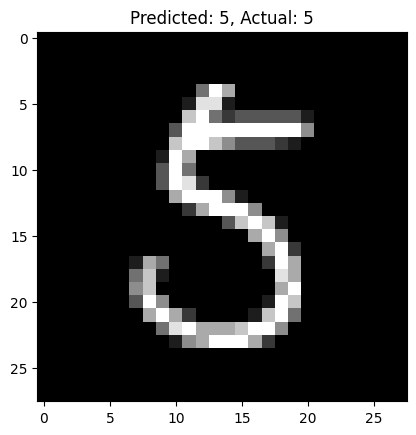

In [ ]:
# Predict a single test sample
sample_index = 153  # Change index to test different samples
sample_image = x_test[sample_index]
sample_label = y_test[sample_index]
sample_logits = model(tf.reshape(sample_image, [-1, 28*28]))
predicted_label = tf.argmax(sample_logits, axis=1).numpy()[0]

# Reshape the sample image back to 28x28 for display
sample_image = sample_image.reshape(28, 28)

plt.imshow(sample_image, cmap='gray')
plt.title(f'Predicted: {predicted_label}, Actual: {np.argmax(sample_label)}') # Get the actual digit from one-hot encoded label
plt.show()

# PyTorch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define PyTorch model
class PyTorchModel(nn.Module):
    def __init__(self):
        super(PyTorchModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x


In [ ]:
# Initialize model, loss function, and optimizer
model = PyTorchModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).view(-1, 28*28).to(device)
# Change to original y_train, before one-hot encoding
y_train_tensor = torch.tensor(y_train.argmax(axis=1), dtype=torch.long).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).view(-1, 28*28).to(device)
# Change to original y_test, before one-hot encoding
y_test_tensor = torch.tensor(y_test.argmax(axis=1), dtype=torch.long).to(device)

In [ ]:
# Training loop
num_epochs = 5
batch_size = 32

def train_model():
    for epoch in range(num_epochs):
        for i in range(0, len(x_train_tensor), batch_size):
            x_batch = x_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

train_model()

Epoch 1, Loss: 1.4676
Epoch 2, Loss: 1.4652
Epoch 3, Loss: 1.4616
Epoch 4, Loss: 1.4905
Epoch 5, Loss: 1.4873


In [ ]:
# Evaluation
with torch.no_grad():
    outputs = model(x_test_tensor)
    predictions = torch.argmax(outputs, axis=1)
    accuracy = (predictions == y_test_tensor).float().mean()
    print(f'Test Accuracy: {accuracy.item() * 100:.2f}%')

Test Accuracy: 96.10%


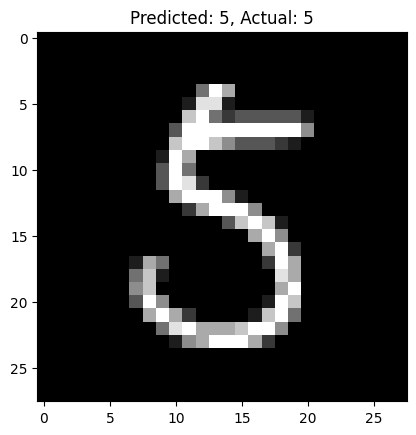

In [ ]:
# Predict a single test sample
sample_index = 153  # Change index to test different samples
sample_image = x_test_tensor[sample_index].cpu().numpy().reshape(28, 28)
sample_label = y_test_tensor[sample_index].cpu().numpy()
sample_logits = model(x_test_tensor[sample_index].view(1, -1))
predicted_label = torch.argmax(sample_logits, axis=1).cpu().numpy()[0]

plt.imshow(sample_image, cmap='gray')
plt.title(f'Predicted: {predicted_label}, Actual: {sample_label}')
plt.show()

# Keras

In [ ]:
# Keras implementation
import keras
from keras import layers

In [ ]:
# Load MNIST dataset
(xt_train, yt_train), (xt_test, yt_test) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape the data to match the model's input shape
xt_train = xt_train.astype('float32') / 255.0
xt_test = xt_test.astype('float32') / 255.0
xt_train = xt_train.reshape(-1, 28 , 28)  # Reshape for the model
xt_test = xt_test.reshape(-1, 28 , 28)    # Reshape for the model

In [ ]:
# Define the Keras model using model.add() method
model = keras.Sequential()
model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
xt_train.shape

(60000, 28, 28)

In [ ]:
# Train the model
model.fit(xt_train, yt_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8688 - loss: 0.4540 - val_accuracy: 0.9702 - val_loss: 0.1051
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9655 - loss: 0.1108 - val_accuracy: 0.9757 - val_loss: 0.0922
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9777 - loss: 0.0731 - val_accuracy: 0.9758 - val_loss: 0.0842
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9821 - loss: 0.0560 - val_accuracy: 0.9775 - val_loss: 0.0797
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9865 - loss: 0.0429 - val_accuracy: 0.9773 - val_loss: 0.0827


In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9716 - loss: 0.0971
Test Accuracy: 97.60%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


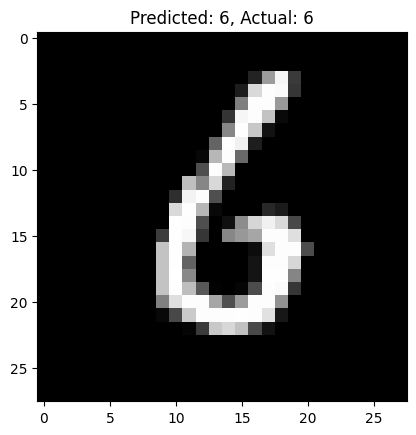

In [ ]:
# Predict a single test sample
sample_index = 50  # Change index to test different samples
sample_image = x_test[sample_index]
sample_label = y_test[sample_index]
predictions = model.predict(sample_image.reshape(1, 28, 28))
predicted_label = np.argmax(predictions)

plt.imshow(sample_image, cmap='gray')
plt.title(f'Predicted: {predicted_label}, Actual: {sample_label}')
plt.show()

# Keras implementation with different backends

In [ ]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import jax
import jax.numpy as jnp
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers, backend

# Load MNIST dataset
(xt_train, yt_train), (xt_test, yt_test) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape the data to match the model's input shape
xt_train = xt_train.astype('float32') / 255.0
xt_test = xt_test.astype('float32') / 255.0
xt_train = xt_train.reshape(-1, 28 , 28)  # Reshape for the model
xt_test = xt_test.reshape(-1, 28 , 28)    # Reshape for the model

# Function to create the model
def create_model():
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Using TensorFlow backend
backend.set_floatx('float32')  # Set default float type
model_tf = create_model()
model_tf.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
model_tf.fit(xt_train, yt_train, epochs=5, batch_size=32, validation_split=0.1)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8737 - loss: 0.4431 - val_accuracy: 0.9670 - val_loss: 0.1128
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9655 - loss: 0.1138 - val_accuracy: 0.9752 - val_loss: 0.0858
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9757 - loss: 0.0778 - val_accuracy: 0.9765 - val_loss: 0.0747
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9824 - loss: 0.0571 - val_accuracy: 0.9745 - val_loss: 0.0861
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9865 - loss: 0.0425 - val_accuracy: 0.9770 - val_loss: 0.0849


In [ ]:
# Using PyTorch backend
import os
os.environ["KERAS_BACKEND"] = "torch"  # Setting the backend before importing keras

# Using PyTorch backend
import keras.backend as K

model_torch = create_model()
model_torch.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
model_torch.fit(xt_train, yt_train, epochs=5, batch_size=32, validation_split=0.1)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8726 - loss: 0.4451 - val_accuracy: 0.9678 - val_loss: 0.1110
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9659 - loss: 0.1110 - val_accuracy: 0.9653 - val_loss: 0.1129
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9761 - loss: 0.0770 - val_accuracy: 0.9718 - val_loss: 0.0944
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9824 - loss: 0.0559 - val_accuracy: 0.9780 - val_loss: 0.0889
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9877 - loss: 0.0433 - val_accuracy: 0.9740 - val_loss: 0.1020


In [ ]:
#!pip install jax jaxlib  # Install JAX if you haven't already
os.environ["KERAS_BACKEND"] = "jax"

# Using JAX backend
import keras.backend as K

model_jax = create_model()
model_jax.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
model_jax.fit(xt_train, yt_train, epochs=5, batch_size=32, validation_split=0.1)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8675 - loss: 0.4477 - val_accuracy: 0.9637 - val_loss: 0.1177
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9652 - loss: 0.1173 - val_accuracy: 0.9757 - val_loss: 0.0840
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9765 - loss: 0.0752 - val_accuracy: 0.9753 - val_loss: 0.0833
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9837 - loss: 0.0517 - val_accuracy: 0.9780 - val_loss: 0.0780
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9863 - loss: 0.0419 - val_accuracy: 0.9775 - val_loss: 0.0839


In [ ]:
# Evaluate models
def evaluate_model(model, name):
    test_loss, test_acc = model.evaluate(xt_test, yt_test)
    print(f'{name} Test Accuracy: {test_acc * 100:.2f}%')

evaluate_model(model_tf, "TensorFlow")
evaluate_model(model_torch, "PyTorch")
evaluate_model(model_jax, "JAX")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9688 - loss: 0.1099
TensorFlow Test Accuracy: 97.19%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9638 - loss: 0.1202
PyTorch Test Accuracy: 96.86%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9690 - loss: 0.1054
JAX Test Accuracy: 97.38%
